<a href="https://colab.research.google.com/github/robgon-art/open-clip/blob/main/Create_Captions_with_CoCa_and_OpenCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Captions with CoCa and OpenCLIP

This is based on the Colab, [here](https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_coca.ipynb)

In [1]:
!pip install open_clip_torch transformers==4.30.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.7 MB/s eta 0:00:00


# Get input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

In [2]:
data = [
["https://live.staticflickr.com/65535/48545607901_8200f85f06.jpg", "photos/48545607901_8200f85f06.jpg", "Rancho Grande Restaurant sign, E. 11th Street, Tulsa, Oklahoma"],
["https://live.staticflickr.com/2106/2178387761_e6e63fb095.jpg", "photos/2178387761_e6e63fb095.jpg", "Children aiming sticks as guns, lined up against a brick building, Washington, D.C.?"],
["https://live.staticflickr.com/7795/26246790753_bf28b47e74.jpg", "photos/26246790753_bf28b47e74.jpg", "Prince Li of Korea"],
["https://live.staticflickr.com/65535/52639014073_1d7e09afac.jpg", "photos/52639014073_1d7e09afac.jpg", "Field Trials, Marshall Field Estate, Long Island (Cold Spring Harbor)"],
["https://live.staticflickr.com/4554/38290258711_c17067b136.jpg", "photos/38290258711_c17067b136.jpg", "Bob's Java Jive, Route 99, Tacoma, Washington"],
["https://live.staticflickr.com/813/26022621907_075ae5ecd2.jpg", "photos/26022621907_075ae5ecd2.jpg", "painting"]
]

In [3]:
import urllib.request
import textwrap
import os

path_names = []
descriptions = []

# Create a folder to save the photos
folder = "photos"
if not os.path.exists(folder):
  os.makedirs(folder)

for d in data:
  # Retrieve the list of photos
  url = d[0]
  caption = d[2]
  caption = caption.replace("(LOC)", "").replace("[", "").replace("]","").strip()
  path_name = d[1]
  urllib.request.urlretrieve(url, path_name)
  path_names.append(path_name)
  descriptions.append(caption)
  print(url, path_name, caption)

https://live.staticflickr.com/65535/48545607901_8200f85f06.jpg photos/48545607901_8200f85f06.jpg Rancho Grande Restaurant sign, E. 11th Street, Tulsa, Oklahoma
https://live.staticflickr.com/2106/2178387761_e6e63fb095.jpg photos/2178387761_e6e63fb095.jpg Children aiming sticks as guns, lined up against a brick building, Washington, D.C.?
https://live.staticflickr.com/7795/26246790753_bf28b47e74.jpg photos/26246790753_bf28b47e74.jpg Prince Li of Korea
https://live.staticflickr.com/65535/52639014073_1d7e09afac.jpg photos/52639014073_1d7e09afac.jpg Field Trials, Marshall Field Estate, Long Island (Cold Spring Harbor)
https://live.staticflickr.com/4554/38290258711_c17067b136.jpg photos/38290258711_c17067b136.jpg Bob's Java Jive, Route 99, Tacoma, Washington
https://live.staticflickr.com/813/26022621907_075ae5ecd2.jpg photos/26022621907_075ae5ecd2.jpg painting


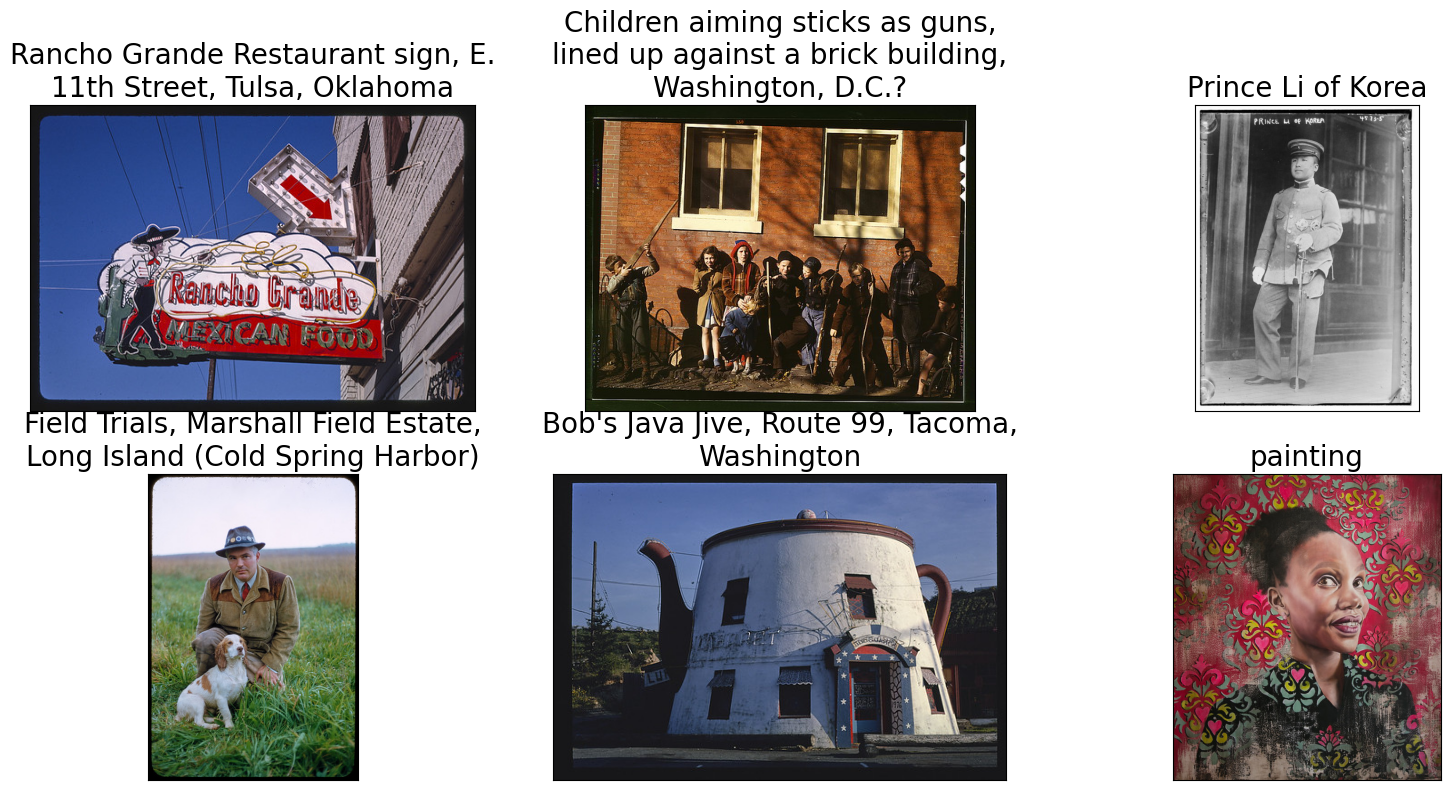

In [4]:
import matplotlib.pyplot as plt
import skimage
from PIL import Image
import textwrap

plt.figure(figsize=(16, 8))
i=0
for path_name, description in list(zip(path_names, descriptions)):
  image = Image.open(path_name).convert("RGB")
  plt.subplot(2, 3, i+1)
  plt.imshow(image)
  description_wrapped = "\n".join(textwrap.wrap(description, width=36)[:3])
  plt.title(description_wrapped, size=20, y=1.0)
  plt.xticks([])
  plt.yticks([])
  i += 1

plt.tight_layout()

In [5]:
import open_clip
import torch

model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)
model.cuda().eval()

CoCa(
  (text): TextTransformer(
    (token_embedding): Embedding(49408, 768)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(1

In [6]:
print(len(path_names))

6


In [7]:
new_captions = []
for path_name in path_names:
  im = Image.open(path_name).convert("RGB")
  im = transform(im).unsqueeze(0).cuda()
  with torch.no_grad(), torch.cuda.amp.autocast():
    generated = model.generate(im)
  caption = open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")[:-2]
  new_captions.append(caption)

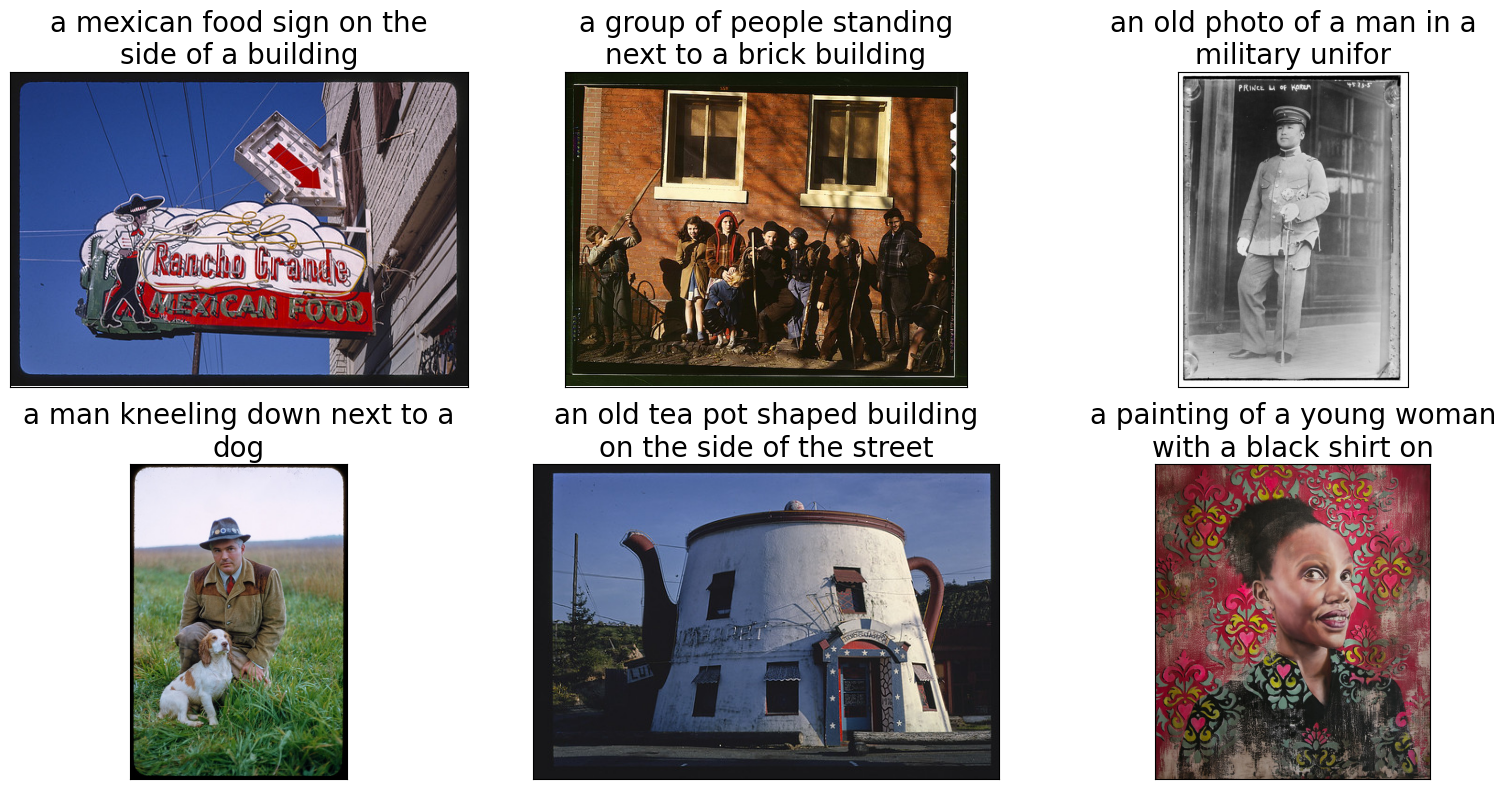

In [8]:
plt.figure(figsize=(16, 8))
i=0

for path_name, description in list(zip(path_names, new_captions)):
  image = Image.open(path_name).convert("RGB")
  plt.subplot(2, 3, i + 1)
  plt.imshow(image)
  description_wrapped = "\n".join(textwrap.wrap(description, width=30))
  plt.title(description_wrapped, size=20, y=1)
  plt.xticks([])
  plt.yticks([])
  i += 1

plt.tight_layout()